In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/m100_work/IscrC_XEXIN/Germanene/GW_HF_analysis'


In [41]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 16
cpus_per_task = 2
omp_num_threads = 2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True,reformat=False) #,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False,
 'reformat': False}

In [ ]:
# RunRules for m100
nodes = 8 # 32
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',#,qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

# BSE analysis of the Germanene

We solve the BSE equations and computed the optical spectrum of the Germanene.

We analyze the excitonic spectrum to understand if the system behaves as an excitonic
insulator.

In [44]:
run_dir = 'GW_HF_analysis/kpoints_81-nbnds_700-vac_4/'
ndbQP = 'pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700/ndb.QP'

In [45]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

## Absorption spectrum in the IP regime

In [46]:
ntasks_c = 16 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -o c -V all',folder=run_dir)

inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']

inp['variables']['LongDrXd'] = [[1.,0.,0.],''] # electric field
inp['variables']['DmRngeXd'] = [[0.005,0.005],'eV'] # damping range
inp['variables']['EnRngeXd'] = [[0,1],'eV'] # energy range
inp['variables']['BndsRnXd'] = [[25,32],''] # bands used for transitions
inp['variables']['QpntsRXd'] = [[1,1],''] # momentum transfer

inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

idd = 'ip_absorption'
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_rim_cutoff','ndb_dipoles'])

idd = 'gw_absorption'
inp['variables']['XfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_rim_cutoff','ndb_dipoles'])

16 2
Initialize a Dataset with 1 parallel tasks


In [47]:
#study.runs[1]

In [48]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
delete job_out script: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/job_ip_absorption.out
delete folder: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ip_absorption
run command: mpirun -np 32 yambo -F ip_absorption.in -J "ip_absorption,ndb_rim_cutoff,ndb_dipoles" -C ip_absorption
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ ; sbatch job_ip_absorption.sh
computation ip_absorption is running...
computation ip_absorption ended
Run performed in 12s
Task [0] ended 
 
Run the task [1] 
delete job_out script: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/job_gw_absorption.out
delete folder: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/gw_absorption
run command: mpirun -np 32 yambo -F gw_absorption.in -J "gw_absorption,ndb_rim_cutoff,ndb_dipoles" -C gw_absorption
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ ; sbatch job_gw_absorption.sh
computation gw_absorption is running...
computation gw_

In [49]:
ip,gw = results[0].data,results[1].data
ip.keys()

dict_keys(['eps_q1_ip', 'alpha_q1_ip'])

In [50]:
energies = ip['eps_q1_ip']['col0']
ip_abs = ip['eps_q1_ip']['col1']
gw_abs = gw['eps_q1_ip']['col1']

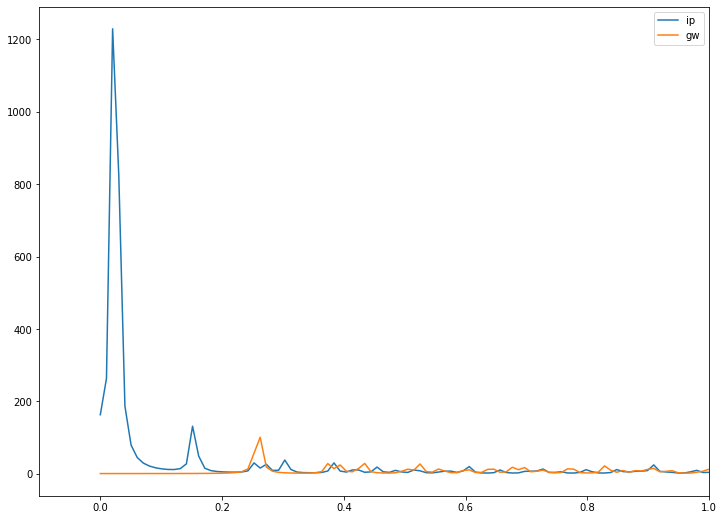

In [51]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(energies,ip_abs,label='ip')
plt.plot(energies,gw_abs,label='gw')
plt.xlim(-0.1,1)
plt.legend()

In [52]:
energies[np.where(gw_abs==max(gw_abs))[0][0]],energies[np.where(ip_abs==max(ip_abs))[0][0]],

(0.262626261, 0.0202020202)

In [53]:
results[0].

In [30]:
file = 'GW_HF_analysis/kpoints_81-nbnds_700-vac_4/pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700/o-pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700.qp'
yambo_data = P.YamboOutputParser([file])

Parse file GW_HF_analysis/kpoints_81-nbnds_700-vac_4/pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700/o-pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700.qp


In [33]:
yambo_data.get_energy?

Signature: yambo_data.get_energy(k, bnd, verbose=False)
Docstring:
Compute the energy (in eV) of the selected state with k and bnd indexes.
The method is implemented for the 'hf' and 'qp' runleves. In the first case
it seeks for the 'Ehf' variable while in the former it looks for the 'E' variable
(written only with the extendOut option enabled!).
In the other cases a warning is created.

Args:
    k (:py:class:`int`): k-point index
    bnd (:py:class:`int`) : band index

Return:
    (:py:class:`float`) : the value of the energy in eV
File:      ~/Applications/MPPI/mppi/Parsers/YamboOutputParser.py
Type:      method


In [35]:
file = 'DFT_analysis-vac_4/kpoints_81-nbnds_700.save/data-file-schema.xml'
dft_data = P.PwParser(file)

Parse file : DFT_analysis-vac_4/kpoints_81-nbnds_700.save/data-file-schema.xml


In [37]:
dft_data.get_transitions?

Signature:
dft_data.get_transitions(
    initial='full',
    final='empty',
    set_scissor=None,
    set_gap=None,
    set_direct_gap=None,
)
Docstring:
Compute the (vertical) transitions energies. For each kpoint compute the transition energies, i.e.
the (positive) energy difference (in eV) between the final and the initial states.

Args:
    initial (string or list) : specifies the bands from which electrons can be extracted. It can be set to `full` or
        `empty` to select the occupied or empty bands, respectively. Otherwise a list of bands can be
        provided
    final  (string or list) : specifies the final bands of the excited electrons. It can be set to `full` or
        `empty` to select the occupied or empty bands, respectively. Otherwise a list of bands can be
        provided
    set_scissor (:py:class:`float`) : set the value of the scissor (in eV) that is added to the empty bands.
        If a scissor is provided the set_gap and set_direct_gap parameters are ignor

In [ ]:
###############################################à

In [34]:
eps = r['eps_q1_ip']
#eps = r['alpha_q1_ip']

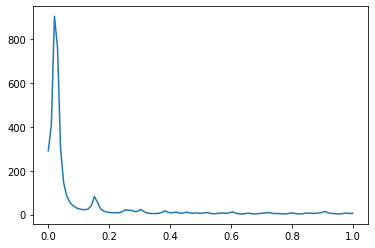

In [35]:
plt.plot(eps['col0'],eps['col1'])

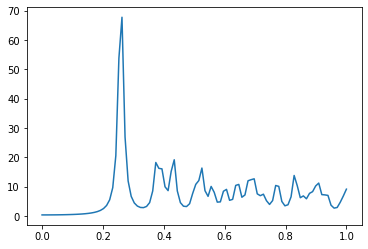

In [21]:
plt.plot(eps['col0'],eps['col1'])

## Computation of the BSE Kernel for subsequent diagonalization

In [6]:
BSENGexx = 11000 #11000
BSENGBlk = 300 
BSEBands = [25,32]
ntasks_c = 16 # ismhpc: 16 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -o b -k sex -V all',folder=run_dir)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']

inp['variables']['BSENGexx'] = [BSENGexx,'RL'] 
inp['variables']['BSENGBlk'] = [BSENGBlk,'RL']
inp['variables']['BSEBands'] = [BSEBands,'']

inp['variables']['KfnQPdb']= 'E < %s'%ndbQP

# Parallel roles
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['BS_ROLEs'] = 'k.eh.t' 
inp['variables']['BS_CPU'] = '4.8.1' # 2 nodes ismhpc and 8 nodes m100

#inp

16 2


In [7]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'bse-BSENGexx_%s-BSENGblk_%s-BSEBands_%s-%s'%(BSENGexx,BSENGBlk,BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300',\
                            'ndb_double_grid','allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300'])

Initialize a Dataset with 1 parallel tasks


In [8]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700/',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -o b -k sex -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'bse', 'optics', 'setup', 'photolum'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'DIP_Threads': [0.0, ''],
   'BS_nCPU_LinAlg_INV': [-1.0, ''],
   'BS_nCPU_LinAlg_DIAGO': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'DipoleEtresh': [1e-05, 'eV'],
   'DbGdQsize': [-1.0, ''],
   'BSENGexx': [11000, 'RL'],
   'BSENGBlk': [300, 'RL'],


In [ ]:
study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.in -J "bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid,allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300" -C bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.sh
computation bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32 is running...
Submitted batch job 5912416


## Solution of the BSE equations without I/O of the BSE Kernel

In [15]:
BSENGexx = 11000 #11000
BSENGBlk = 300 #300 
BSEBands = [25,32]
BEnRange = [-1.,1.] # eV
ntasks_c = 16 # ismhpc: 16 for 2 nodes # m100: 8 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -o b -k sex -y s -V all',folder=run_dir)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']

inp['variables']['DBsIOoff'] = 'BS'

inp['variables']['BSENGexx'] = [BSENGexx,'RL'] 
inp['variables']['BSENGBlk'] = [BSENGBlk,'RL']
inp['variables']['BSEBands'] = [BSEBands,'']

inp['variables']['BEnRange'] = [BEnRange,'eV']
inp['variables']['BEnSteps']  = [1000,'']
inp['variables']['BDmRange'] = [[0.01,0.01],'eV']

inp['variables']['KfnQPdb']= 'E < %s'%ndbQP

inp['variables']['BSEprop'] = 'abs esrt jdos'
inp['variables']['BSSNEig'] = [20,'']

# Parallel roles
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['BS_ROLEs'] = 'k.eh.t' 
inp['variables']['BS_CPU'] = '4.8.1' # 2 nodes ismhpc and 8 nodes m100
#inp['variables']['BS_CPU'] = '1.8.1' # 2 nodes m100

#inp

16 2


In [16]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'bse_diago-BSENGexx_%s-BSENGblk_%s-BSEBands_%s-%s'%(BSENGexx,BSENGBlk,BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300',\
                            'ndb_double_grid','allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300'])

Initialize a Dataset with 1 parallel tasks


In [17]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700/',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -o b -k sex -y s -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut',
   'bse',
   'optics',
   'bss',
   'setup',
   'WRbsWF',
   'photolum'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'DIP_Threads': [0.0, ''],
   'BS_nCPU_LinAlg_INV': [-1.0, ''],
   'BS_nCPU_LinAlg_DIAGO': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'DipoleEtresh': [1e-05, 'eV'],
   'DbGdQsize': [-1.0, ''],
   'BSENGexx': [11

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.in -J "bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid,allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300" -C bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.sh
computation bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32 is running...
Submitted batch job 5911170


In [91]:
r = results[0].data

In [92]:
r.keys()

dict_keys(['in', 'GW_HF_analysis/kpoints_60-nbnds_700/bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32/r-bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32_rim_cut_optics_dipoles_bss_bse', 'eps_q1_slepc_bse', 'alpha_q1_slepc_bse', 'jdos_q1_slepc_bse', 'E_IP_q1', 'Esort_q1_slepc_bse'])

In [93]:
eps = r['eps_q1_slepc_bse']

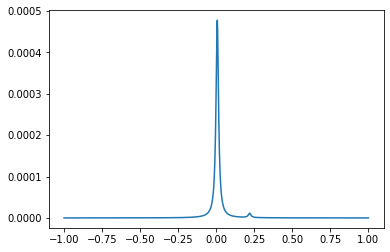

In [94]:
plt.plot(eps['col0'],eps['col1'])

In [101]:
jdos = r['jdos_q1_slepc_bse']

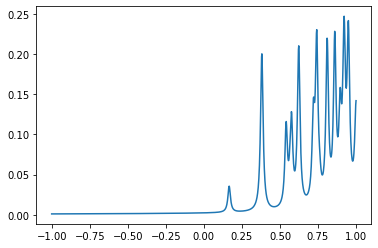

In [106]:
plt.plot(jdos['col0'],jdos['col3'])

In [97]:
energies = Tools.get_variable_from_db(
        'GW_HF_analysis/kpoints_60-nbnds_700/bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32_old/ndb.BS_diago_Q1','BS_Energies')
energies *= Const.HaToeV*1e3

In [100]:
energies[0:10]

array([[  6.6400695,   0.       ],
       [  6.645164 ,   0.       ],
       [  7.1321254,   0.       ],
       [  7.13764  ,   0.       ],
       [  7.6836133,   0.       ],
       [  7.6873198,   0.       ],
       [  7.848302 ,   0.       ],
       [  7.848533 ,   0.       ],
       [212.92122  ,   0.       ],
       [212.92865  ,   0.       ]], dtype=float32)